In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import GridSearchCV

In [3]:
folder_path = '../datasets/data-transformed'
json_files = glob.glob(f'{folder_path}/*.json.gz')
posts = pd.concat((pd.read_json(f, compression='gzip', lines=True) for f in json_files))

# Reviewing Dataset
Lets take a look at the frequency distribution of our data and the scores our dataset has

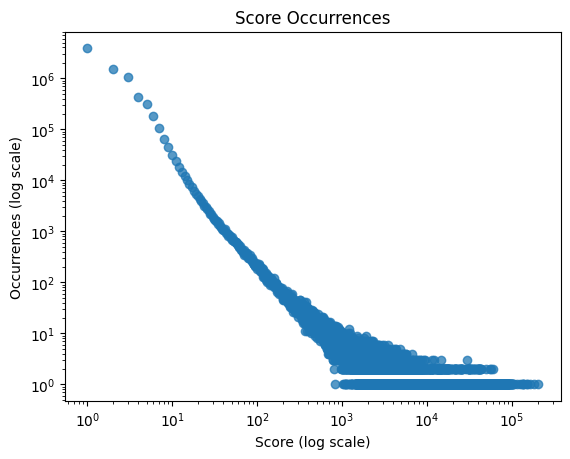

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each score
score_counts = posts['score'].value_counts().sort_index()

# Plot the data with a log scale on both axes
plt.scatter(score_counts.index, score_counts.values, alpha=0.75)
plt.xscale('log')
plt.yscale('log')
plt.title('Score Occurrences')
plt.xlabel('Score (log scale)')
plt.ylabel('Occurrences (log scale)')
plt.show()

Looks like our dataset is extremely right skewed, and scores exist in the range [0, 300000]

# Model Creation and Evaluation
Start by choosing the features used to train the models, and split testing/training data.

In [5]:
# Select features and target variable
features = posts[['age_when_retrieved', 'year', 'month', 'day', 'hour', 'day_of_week', 'post_count', 'over_18', 'gilded', 'archived', 'quarantine', 'stickied', 'num_comments', 'title_length']]
target = posts['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# For the random forest regression model, I'm using the hyperparemeters used here: https://towardsdatascience.com/predicting-reddit-comment-karma-a8f570b544fc
# resources to find the optimal hyperaparmeters (limited computing power) as I do not have sufficient

## Creating Pipelines

In [6]:
# Hyperparameter tuning for Decision Tree
param_grid = {
    'min_samples_split': [50, 60, 70],
    'min_samples_leaf': [50, 60, 70],
}
dt_model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
dt_model = grid_search.best_estimator_

# Create models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 42)
knn_model = KNeighborsRegressor()
mean_dummy_model = DummyRegressor(strategy="mean")
median_dummy_model = DummyRegressor(strategy="median")

# Create pipelines
linear_pipeline = Pipeline([('scaler', StandardScaler()), ('model', linear_model)])
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('model', rf_model)])
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('model', knn_model)])
dt_pipeline = Pipeline([('scaler', StandardScaler()), ('model', dt_model)])
mean_dummy_pipeline = Pipeline([('model', mean_dummy_model)])
median_dummy_pipeline = Pipeline([('model', median_dummy_model)])

pipelines = [linear_pipeline, rf_pipeline, knn_pipeline, dt_pipeline, mean_dummy_pipeline, median_dummy_pipeline]
model_names = ['Linear Regression', 'Random Forest', 'KNN', 'Decision Tree', 'Mean Dummy', 'Median Dummy']


## Model Training

In [7]:
# Train and store results for each model
results = []

for pipeline, model_name in zip(pipelines, model_names):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    
    result = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R^2': r2
    }
    
    results.append(result)

    print(result)

results = pd.DataFrame(results)

{'Model': 'Linear Regression', 'MAE': 23.678504841943894, 'RMSE': 402.17307641043277, 'R^2': 0.7117533053235087}
{'Model': 'Random Forest', 'MAE': 8.362980122000911, 'RMSE': 318.1229676375029, 'R^2': 0.8196449115855539}
{'Model': 'KNN', 'MAE': 9.269258169196519, 'RMSE': 363.2314554833845, 'R^2': 0.7648715119018463}
{'Model': 'Decision Tree', 'MAE': 8.587450873857907, 'RMSE': 330.62217481216675, 'R^2': 0.8051940102786826}
{'Model': 'Mean Dummy', 'MAE': 34.99604013960664, 'RMSE': 749.0851359299301, 'R^2': -1.6310135459995934e-06}
{'Model': 'Median Dummy', 'MAE': 18.54108049118893, 'RMSE': 749.3088268678878, 'R^2': -0.0005989588506338794}


# Model Evaluation

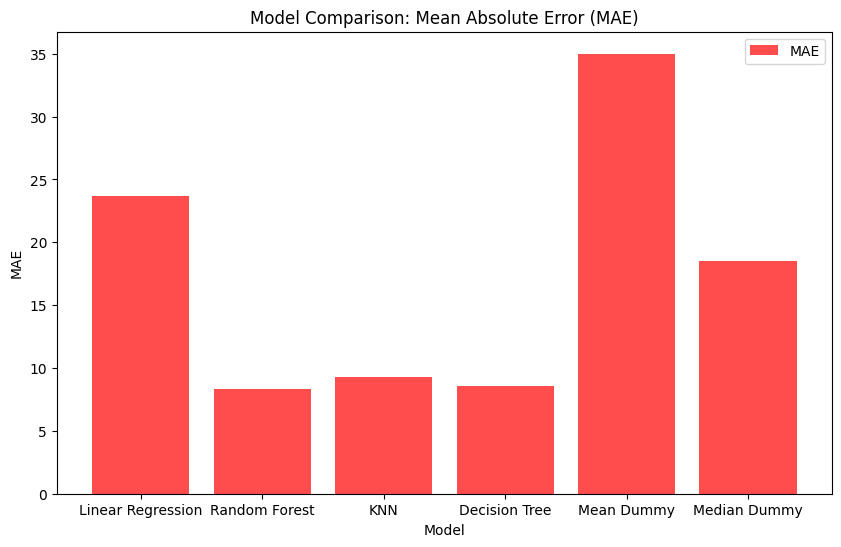

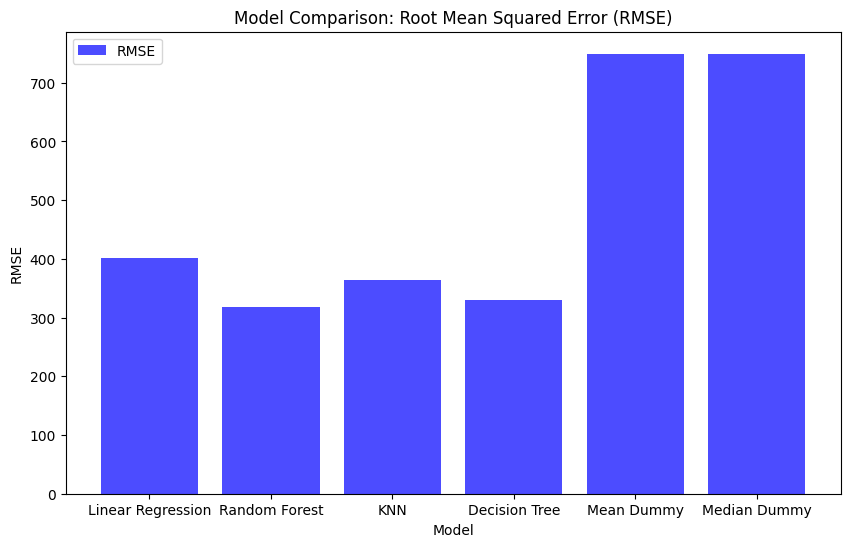

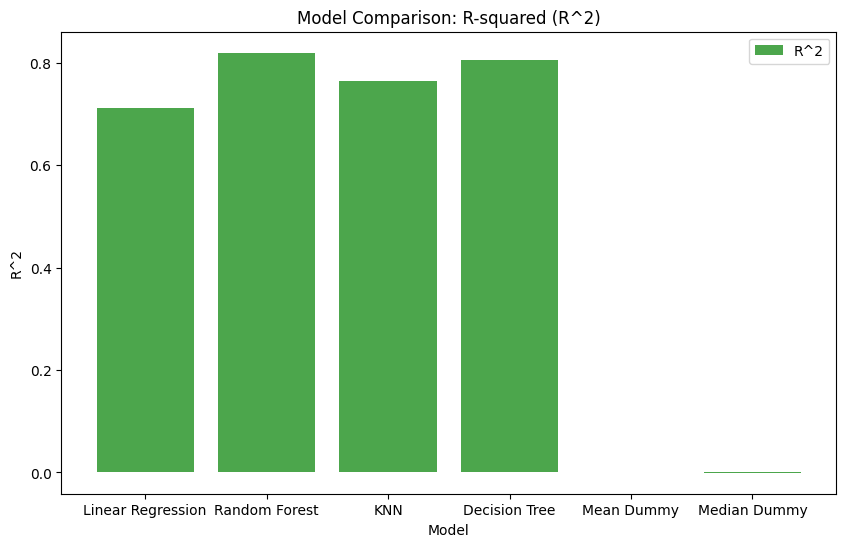

In [8]:
models = results['Model']
mae_values = results['MAE']
rmse_values = results['RMSE']
r2_values = results['R^2']

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='red', alpha=0.7, label='MAE')
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plotting RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='blue', alpha=0.7, label='RMSE')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plotting R^2
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='green', alpha=0.7, label='R^2')
plt.title('Model Comparison: R-squared (R^2)')
plt.xlabel('Model')
plt.ylabel('R^2')
plt.legend()
plt.show()

After taking a look at our errors and R^2 value, we can come to the following conclusions
- Random Forest and Decision Tree model exhibit strong performance, outperforming the other models based on RMSE, MAE, and R^2
- Both baseline dummy regressor models (median and mean) perform poorly, emphasizing the need for more sophisticated models to achieve better predictions
- KNN and Random Forest models could improve with hyperparameter tuning (with more compute power)
- KNN and Decision Tree models are quite cheap to train, with similar performance to Random Forest 

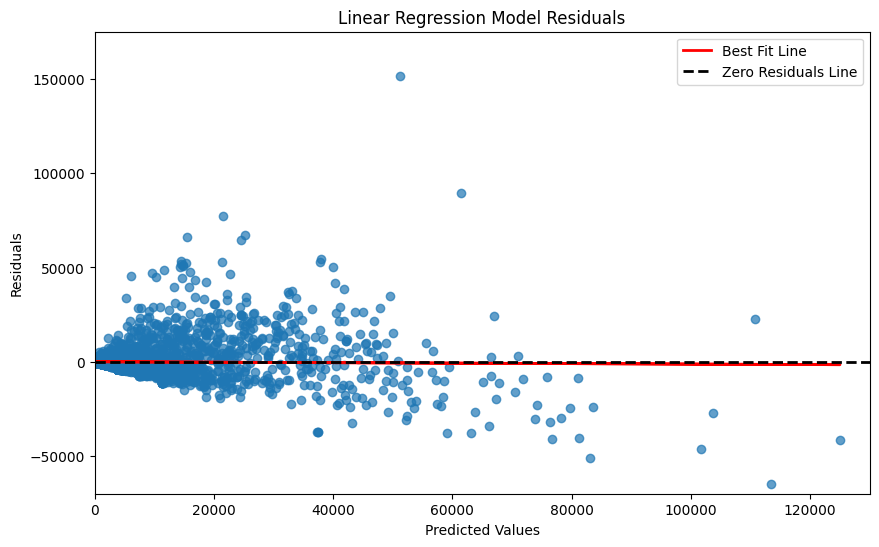

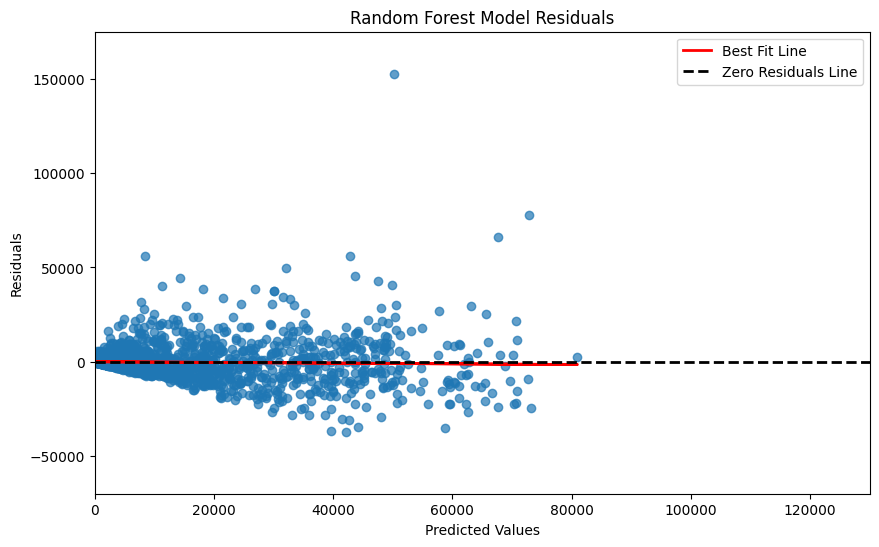

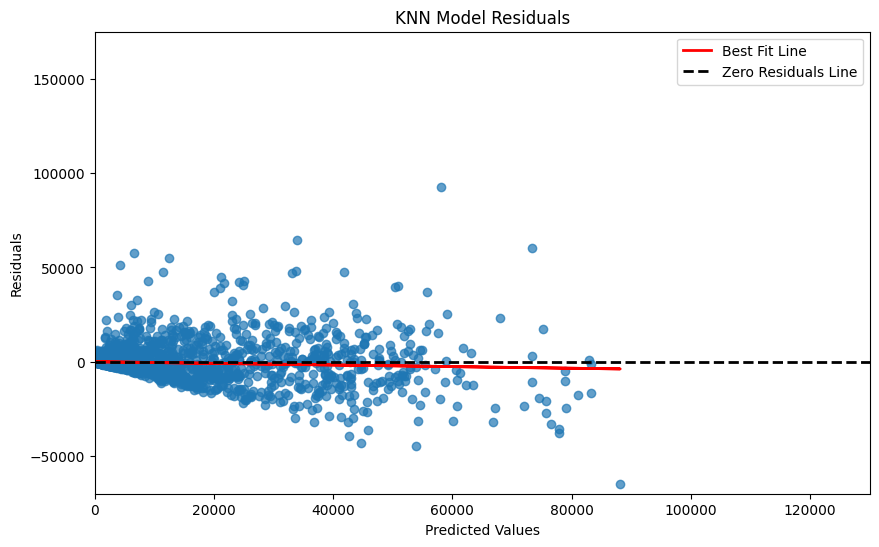

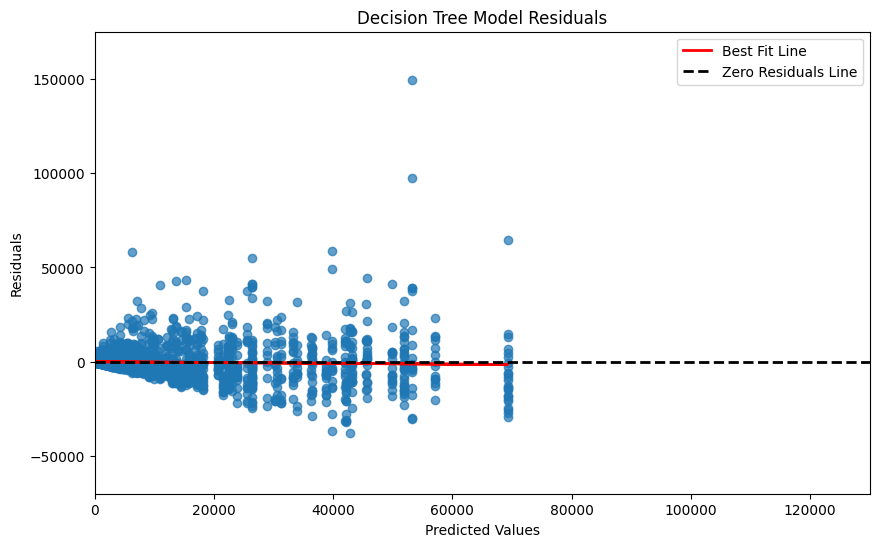

In [9]:
def plot_residuals(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    residuals = y_test - predictions

    lr_residuals = LinearRegression()
    lr_residuals.fit(predictions.reshape(-1, 1), residuals)
    best_fit_line = lr_residuals.predict(predictions.reshape(-1, 1))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.7)
    plt.plot(predictions, best_fit_line, color='red', linewidth=2, label='Best Fit Line')
    plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Zero Residuals Line')
    plt.title(f'{model_name} Model Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.xlim(0, 130000)
    plt.ylim(-70000, 175000)
    plt.show()

# Plot Residuals for each model
plot_residuals(linear_pipeline, X_test, y_test, 'Linear Regression')
plot_residuals(rf_pipeline, X_test, y_test, 'Random Forest')
plot_residuals(knn_pipeline, X_test, y_test, 'KNN')
plot_residuals(dt_pipeline, X_test, y_test, 'Decision Tree')

# both median and mean predictions have similar looking plots

**Linear Regression**
- The predicted values are 50% larger than all other models
- The model has positive residuals with low predictions and negative residuals with high predictions
- There is a larger spread of residuals when compared to other models

**Random Forest** and **KNN**
- Both of these models have very similar distributions
- KNN seems to predict scores more conservatively when compared to Random Forest
- Random Forest has a tighter residual spread when compared to KNN
- Random forest predicts scores above 60000 more accurately than all other models

**Decision Tree**
- From 0 to 20000, predictions seem to be continuous
- From 20000 onwards, predictions are equally spaced out
- There seem to be more positive residual outliers on predictions when compared to KNN
- There is a heavier concentration of predictes values around 70000 when compared to other models
- Predictions for scores below 20000 are more accurate than other models

**Overall**
- All models predict low scores more frequently than high scores

# Performance Evaluation

In [10]:
def get_ratio(model_name):
    model_index = models[models == model_name].index[0]

    # Calculate the differences
    mae_differences = 100 * (mae_values - mae_values[model_index]) / mae_values[model_index]
    rmse_differences = 100 * (rmse_values - rmse_values[model_index]) / rmse_values[model_index]
    r2_differences = 100 * (r2_values - r2_values[model_index]) / r2_values[model_index]

    # Create a new DataFrame to display the differences
    differences_df = pd.DataFrame({
        'Model': models,
        'MAE % Difference': mae_differences,
        'RMSE % Difference': rmse_differences,
        'R² % Difference': r2_differences
    })

    # Print the differences DataFrame
    print(f'Differences as a percentage in Error and R² Values Compared to {model_name}:\n')
    print(differences_df.to_string(index=False))

for cur_model in models:
    get_ratio(cur_model)

print(f'\nRaw Vaues:\n{results}')

Differences as a percentage in Error and R² Values Compared to Linear Regression:

            Model  MAE % Difference  RMSE % Difference  R² % Difference
Linear Regression          0.000000           0.000000         0.000000
    Random Forest        -64.681131         -20.898989        15.158568
              KNN        -60.853702          -9.682802         7.463008
    Decision Tree        -63.733137         -17.791072        13.128243
       Mean Dummy         47.796664          86.259394      -100.000229
     Median Dummy        -21.696574          86.315015      -100.084153
Differences as a percentage in Error and R² Values Compared to Random Forest:

            Model  MAE % Difference  RMSE % Difference  R² % Difference
Linear Regression        183.134774          26.420635       -13.163213
    Random Forest          0.000000           0.000000         0.000000
              KNN         10.836783          14.179576        -6.682577
    Decision Tree          2.684100           

The data above shows how each model performs in comparison to each other model and their raw values.

After exploring three alternatives to Linear Regression (our original approach in predict_score_old.py), we've found a model that has:
- 65% lower MAE
- 15% higher R^2
- 21% lower RMSE

This model is Random Forest Regression.

# Next Steps

Next steps in this project include
- Tuning the hyperparameters for Random Forest and KNN
- Adding new features using semantic analysis and text embeddings
- Testing the performance/viability of neural networks
- Testing how undersampling of low scored posts affects model accuracy
- Testing how feature selection affects model accuracy


PS: you should hire me :)